In [55]:
import pandas as pd
import numpy as np
import OpenBlender
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Our aim would be to use news data to predict the change in crypto market, i.e whether the crypto price would rise or whether it would fall

In [2]:
# token is the api_token from the OpenBlender website
token = '61ce61a8951629611006f2269J5j02pXQbB9LsEptb2hpwjOw2yWtI'
action = 'API_getObservationsFromDataset'

# we are using Bitcoin vs USD, which is Daily exchange rate of US dollar vs Bitcoin
parameters = { 
    'token' : token,
    'id_dataset' : '5d4c3af79516290b01c83f51',
    'date_filter':{"start_date" : "2020-05-01",
                   "end_date" : "2021-01-30"} 
}
# reading the json response of the API into pandas dataframe
data = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
data.reset_index(drop=True, inplace=True)
# converting timestamp to date 
data['date'] = [OpenBlender.unixToDate(ts, timezone = 'GMT') for ts in data.timestamp]
data = data.drop('timestamp', axis = 1)

Task ID: '61df38e20895fafb4a9d8d4b'.
Total estimated consumption: 500.02 processing units.
100.0 % completed.


In [3]:
# generate the target variable which is whether the crypto price increased or declined
# we are subtracting the closing price and opening price
data['log_diff'] = np.log(data['price']) - np.log(data['open'])

In [4]:
# let's generate the target variable based on log_diff, if greater than 0, it means rise, if less than 0 it means decline
data['target'] = [1 if log_diff > 0 else 0 for log_diff in data['log_diff']]

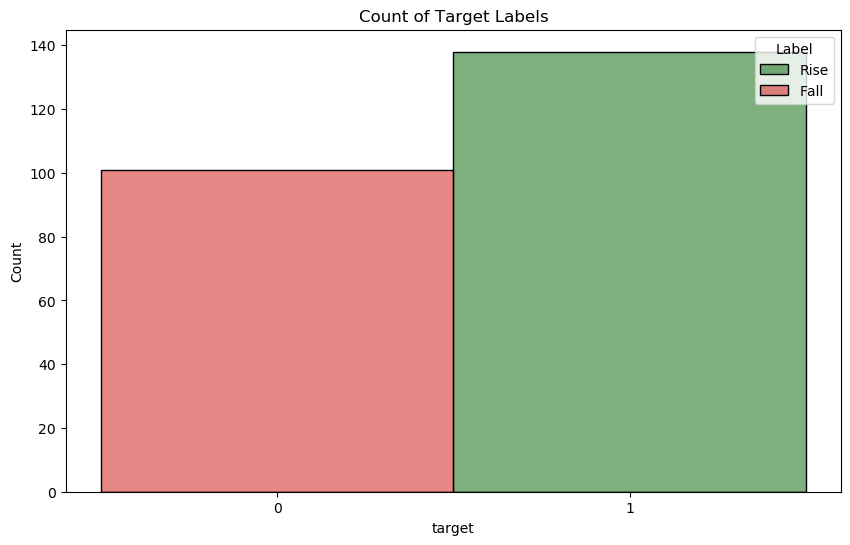

In [5]:
# let's look at the count of the target variables
plt.subplots(figsize=(10,6))
target_data = data.copy()
target_data["target"]=target_data["target"].astype(str)
plot=sns.histplot(data=target_data,x="target",hue="target",palette=["#d1120f","#006400"],legend="target")
plt.title("Count of Target Labels")
plt.legend(title='Label', loc='upper right', labels=['Rise', 'Fall'])
plt.show(plot)


In [6]:
data.head()

,volume,price,high,low,open,change,date,log_diff,target
0,14.77K,30454.0,32519.0,29815.0,32519.0,-6.35%,27-01-2021 17:00:00,-0.065607,0
1,8.54K,32519.0,32735.1,31434.0,32268.1,0.78%,26-01-2021 17:00:00,0.007745,1
2,9.23K,32268.1,34693.0,32268.1,32298.0,-0.09%,25-01-2021 17:00:00,-0.000926,0
3,5.89K,32298.0,32830.0,31481.0,32099.0,0.62%,24-01-2021 17:00:00,0.006180,1
4,7.07K,32099.0,33062.0,31773.0,33062.0,-2.91%,23-01-2021 17:00:00,-0.029560,0


In [7]:
# Now, we want to mix external news data with our bitcoin data, to do so we will time-blend. 
# In other words, it means to outer join the news dataset using the timestamp as key.
format = '%d-%m-%Y %H:%M:%S'
timezone = 'GMT'

# The Unix Timestamp is the number of seconds since 1970 on UTC 
# it is a very preferred format because it is the same in every time zone in the world

data['timestamp'] = OpenBlender.dateToUnix(data['date'], 
                                           date_format = format, 
                                           timezone = timezone)
data = data[['date', 'timestamp', 'price', 'target']]
data.head()

,date,timestamp,price,target
0,27-01-2021 17:00:00,1.611767e+09,30454.0,0
1,26-01-2021 17:00:00,1.611680e+09,32519.0,1
2,25-01-2021 17:00:00,1.611594e+09,32268.1,0
3,24-01-2021 17:00:00,1.611508e+09,32298.0,1
4,23-01-2021 17:00:00,1.611421e+09,32099.0,0


In [8]:
# next step would be to concat the news dataset with our bitcoin price dataset
# We need to add the id of the dataset and the feature we want from the dataset.
# as the crypto market data is daily based we would aggregrate the news on daily basis 
blend_source = {
                'id_dataset':'5ea2039095162936337156c9',
                'feature' : 'text'
            }

# Now, let's 'timeBlend' it to our dataset
data_with_news = OpenBlender.timeBlend( token = token, # API token
                                  anchor_ts = data.timestamp, # our timestamp column,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals', # 'agg_in_intervals' because we want 24 hour interval aggregation
                                  interval_size = 60 * 60 * 24,
                                  direction = 'time_prior',
                                  interval_output = 'list',
                                  missing_values = 'raw')
data = pd.concat([data, data_with_news.loc[:, data_with_news.columns != 'timestamp']], axis = 1)
data.head()

Task ID: '61df38e70895fafb4a9d8d4c'.
Total estimated consumption: 1564.8 processing units.
Task confirmed. Starting download..
100%


,date,timestamp,price,target,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days
0,27-01-2021 17:00:00,1.611767e+09,30454.0,0,24,"[, cryptocurrencies have gained popularity in ..."
1,26-01-2021 17:00:00,1.611680e+09,32519.0,1,20,[zelaapayae uae will now have a crypto debit c...
2,25-01-2021 17:00:00,1.611594e+09,32268.1,0,15,[cashpay ecommerce marketplace powered by cry...
3,24-01-2021 17:00:00,1.611508e+09,32298.0,1,15,[oh look the researcher willy woo said suddenl...
4,23-01-2021 17:00:00,1.611421e+09,32099.0,0,18,"[according to wu, the chinese crypto community..."


BITCOIN_NE.text_COUNT_last1days shows the number of news on that day

In [9]:
# let's save our data for the future use
data.to_csv("Input_data.csv", index = False)

In [10]:
# let's merge our list of news on each day, to one string so that we can tokenize
data["news"] = data["BITCOIN_NE.text_last1days"].apply(lambda x: " ".join(x))

In [31]:
# we will convert our text into vectors using word2vec method, a feature extraction approach
import gensim


tokenized_news = data["news"].apply(lambda x: x.split()) # tokenizing

modelW2v = gensim.models.word2vec.Word2Vec(
            tokenized_news,
            vector_size=200,
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 8, # no.of cores
            seed = 34)

modelW2v.train(tokenized_news, total_examples= len(data["news"]), epochs=30)

(565354, 830070)

In [32]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += modelW2v.wv.get_vector(word).reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [33]:
wordvec_arrays = np.zeros((len(tokenized_news), 200))

for i in range(len(tokenized_news)):
    wordvec_arrays[i,:] = word_vector(tokenized_news[i], 200)
    
wordvecDf = pd.DataFrame(wordvec_arrays)
wordvecDf.shape 

(239, 200)

In [34]:
columns_list = ["A"+str(i)for i in range(1,201)]
wordvecDf.columns = columns_list

In [35]:
wordvecDf["target"] = data["target"]

In [36]:
wordvecDf

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A192,A193,A194,A195,A196,A197,A198,A199,A200,target
0,-0.042538,-0.228886,-0.059037,-0.103708,-0.097129,-0.033893,-0.296511,-0.013331,0.177267,0.099675,...,-0.148102,0.061477,-0.139094,0.194812,0.024313,-0.129041,-0.137316,0.165591,0.091323,0
1,0.032600,-0.253509,-0.048974,-0.077029,-0.088107,-0.086062,-0.295636,-0.059222,0.157617,0.082683,...,-0.208200,0.033569,-0.092998,0.192604,0.022613,-0.101395,-0.132008,0.176468,0.090326,1
2,-0.015750,-0.212603,-0.060991,-0.083240,-0.082632,-0.027280,-0.265468,0.008049,0.127977,0.099344,...,-0.158335,0.091057,-0.186122,0.223992,-0.004683,-0.128166,-0.134974,0.128903,0.085254,0
3,-0.038883,-0.198119,-0.027596,-0.098193,-0.093579,-0.041922,-0.252931,0.017633,0.152282,0.088550,...,-0.152391,0.060235,-0.120888,0.215914,0.026346,-0.122340,-0.136149,0.161266,0.084095,1
4,-0.018003,-0.233484,-0.045396,-0.092740,-0.071370,-0.052595,-0.284833,-0.027723,0.149977,0.079216,...,-0.186419,0.050158,-0.121307,0.179218,0.022594,-0.122870,-0.139348,0.143149,0.106351,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.097363,-0.273721,0.019930,-0.018132,-0.011066,-0.039648,-0.227610,-0.091887,0.069283,0.113032,...,-0.149609,0.099851,-0.067998,0.080659,0.011483,-0.131142,-0.057686,0.155034,0.183714,1
235,0.047852,-0.207077,0.014713,-0.042380,-0.045048,0.019001,-0.245337,-0.004328,0.076925,0.065906,...,-0.009202,0.106930,-0.049263,0.160022,0.064750,-0.201429,-0.057170,0.133523,0.183605,0
236,0.109619,-0.253514,0.031097,0.041398,-0.051545,0.025652,-0.320247,-0.091036,0.082658,0.038913,...,-0.209363,0.091578,-0.051194,0.285773,0.057831,-0.144138,-0.037392,0.135877,0.021856,0
237,0.103866,-0.287815,0.017262,-0.042966,-0.073991,-0.003242,-0.322443,-0.063772,0.091021,0.060693,...,-0.112660,0.088304,-0.064588,0.177297,0.029039,-0.114270,-0.050256,0.137920,0.110431,1


### Building Sentiment Analysis on the news

#### Removing Stop Words

In [37]:
# Load list of stop-words
listStopwords = nltk.corpus.stopwords.words("english")

In [38]:
def removeStopWords(text,listStopwords=None):
    listText = text.split()
    if listStopwords is not None:
        # only select words that aren't in the stopwords list
        listText = [word for word in listText if word not in 
                    listStopwords]
        
    text = " ".join(listText)
    return text
    

In [39]:
# apply the removal of stopwords on each news
data["cleaned_news"] = data["news"].apply(lambda x:removeStopWords(x,listStopwords=listStopwords))

#### Tokenizing the news for Lemmatization

In [40]:
# tokenize the news into words so that we can apply lemmatization
tokenized_news= data['cleaned_news'].apply(lambda x: x.split())

In [43]:
# initialize the lemmatizer and lemmatizr Adjectives, Verbs, Noun and Adverbs
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

wordnetLemmatizer = WordNetLemmatizer()
def getWordnetPos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [44]:
tokenized_news = tokenized_news.apply(lambda x: [wordnetLemmatizer.lemmatize(i,getWordnetPos(i)) for i in x])

# join the tokenized words back again after lemmatization so that we have cleaned news
for i in range(len(tokenized_news)):
    tokenized_news[i]=" ".join(tokenized_news[i])
data['cleaned_news'] = tokenized_news

In [45]:
data.head()

,date,timestamp,price,target,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days,news,cleaned_news,polarity_scores,compound_scores,sentiment_class
0,27-01-2021 17:00:00,1.611767e+09,30454.0,0,24,"[, cryptocurrencies have gained popularity in ...",cryptocurrencies have gained popularity in re...,c r y p t o c u r r e n c i e s g a i n p ...,"{'neg': 0.077, 'neu': 0.791, 'pos': 0.132, 'co...",0.9662,Positive
1,26-01-2021 17:00:00,1.611680e+09,32519.0,1,20,[zelaapayae uae will now have a crypto debit c...,zelaapayae uae will now have a crypto debit ca...,z e l a a p a y a e u a e c r y p t o d ...,"{'neg': 0.07, 'neu': 0.782, 'pos': 0.148, 'com...",0.9633,Positive
2,25-01-2021 17:00:00,1.611594e+09,32268.1,0,15,[cashpay ecommerce marketplace powered by cry...,cashpay ecommerce marketplace powered by cryp...,c a s h p a y e c o m m e r c e m a r k e ...,"{'neg': 0.073, 'neu': 0.82, 'pos': 0.107, 'com...",0.8789,Positive
3,24-01-2021 17:00:00,1.611508e+09,32298.0,1,15,[oh look the researcher willy woo said suddenl...,oh look the researcher willy woo said suddenly...,o h l o o k r e s e a r c h e r w i l l ...,"{'neg': 0.071, 'neu': 0.761, 'pos': 0.168, 'co...",0.9712,Positive
4,23-01-2021 17:00:00,1.611421e+09,32099.0,0,18,"[according to wu, the chinese crypto community...","according to wu, the chinese crypto community ...","a c c o r d w u , c h i n e s e c r y p ...","{'neg': 0.059, 'neu': 0.837, 'pos': 0.104, 'co...",0.8402,Positive


#### Applying Sentiment Analysis on the cleaned news 

In [46]:
sid = SentimentIntensityAnalyzer()
data["polarity_scores"] = data["cleaned_news"].apply(lambda x : sid.polarity_scores(x))

the polarity scores contains **Compound Score** which is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

In [47]:
data["compound_scores"] = data["polarity_scores"].apply(lambda x : x.get('compound'))

In [48]:
# let's convert compound scores into positive, neutral and negative class
def get_sentiment_class(compound_score):
    if compound_score >= 0.05 :
        return "Positive"
    elif compound_score <= - 0.05 :
        return "Negative"
    else :
        return "Neutral"

In [49]:
data["sentiment_class"] =  data["compound_scores"].apply(lambda x: get_sentiment_class(x))

In [50]:
data.head()

,date,timestamp,price,target,BITCOIN_NE.text_COUNT_last1days,BITCOIN_NE.text_last1days,news,cleaned_news,polarity_scores,compound_scores,sentiment_class
0,27-01-2021 17:00:00,1.611767e+09,30454.0,0,24,"[, cryptocurrencies have gained popularity in ...",cryptocurrencies have gained popularity in re...,c r y p t o c u r r e n c i e s g a i n p ...,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,Neutral
1,26-01-2021 17:00:00,1.611680e+09,32519.0,1,20,[zelaapayae uae will now have a crypto debit c...,zelaapayae uae will now have a crypto debit ca...,z e l a a p a y a e u a e c r y p t o d ...,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,Neutral
2,25-01-2021 17:00:00,1.611594e+09,32268.1,0,15,[cashpay ecommerce marketplace powered by cry...,cashpay ecommerce marketplace powered by cryp...,c a s h p a y e c o m m e r c e m a r k e ...,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,Neutral
3,24-01-2021 17:00:00,1.611508e+09,32298.0,1,15,[oh look the researcher willy woo said suddenl...,oh look the researcher willy woo said suddenly...,o h l o o k r e s e a r c h e r w i l l ...,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,Neutral
4,23-01-2021 17:00:00,1.611421e+09,32099.0,0,18,"[according to wu, the chinese crypto community...","according to wu, the chinese crypto community ...","a c c o r d w u , c h i n e s e c r y p ...","{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,Neutral


#### correlation between compound scores and our target variable

In [51]:
data[["target", "compound_scores"]].corr()

,target,compound_scores
target,1.0,NaN
compound_scores,NaN,NaN


there seems to be very little correlation between the target variable and the sentiment of our daily news

### Build Models

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score

In [53]:
# splitting data into training and validation set
xtrain, xvalid, ytrain, yvalid = train_test_split(wordvecDf,wordvecDf['target'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [54]:
# build a random forest model
random_forest_model = RandomForestClassifier().fit(xtrain, ytrain)
prediction = random_forest_model.predict(xvalid)
print("Accuracy score",accuracy_score(yvalid, prediction))

Accuracy score 0.9583333333333334
